In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils.layer_utils import count_params
import matplotlib.pyplot as plt
from collections import Counter
from time import time

In [2]:
seed = 2802
test_size = 0.2
batch_size = 12

input_dir = "data/images"
target_dir = "data/mask"

input_shape = (320,320)

epochs =100

f_name = 'efficientnet'

## Load Dataset

In [3]:
df = pd.read_csv('data/dataset_train_test.csv') 
df['path'] = input_dir+'/'+df['image_name']+'.jpg'
df['category_str'] = np.where(df['class']==1, 'NB', np.where(df['class']==2, 'NB', 'BB')) #class_mode binary
df['category'] = np.where(df['class']==1, 0, np.where(df['class']==2, 0, 1)) #class_mode binary

datagen_normal = ImageDataGenerator(rescale=1./255)

train_generator_normal = datagen_normal.flow_from_dataframe(
    df[df['set']=='Train'],
    x_col='path', 
    y_col='category', 
    target_size=input_shape, 
    batch_size=batch_size,
    seed=seed,
    class_mode="raw",
    shuffle=True,)

validation_generator_normal = datagen_normal.flow_from_dataframe(
    df[df['set']=='Test'],
    x_col='path', 
    y_col='category', 
    target_size=input_shape, 
    batch_size=batch_size,
    class_mode="raw",
    seed=seed,
    shuffle=True,)

Found 856 validated image filenames.
Found 215 validated image filenames.


In [4]:
metrics = [
      "accuracy", 
      keras.metrics.Precision(name='precision'), 
      keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.FalseNegatives(name='fn'),
    ]

counts = np.bincount(train_generator_normal.labels)
total = counts[0]+counts[1]
weight_for_0 = (1 / counts[0]) * (total / 2.0)
weight_for_1 = (1 / counts[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
counts, class_weight

(array([663, 193], dtype=int64),
 {0: 0.6455505279034691, 1: 2.2176165803108807})

## Model

In [5]:
#https://keras.io/api/applications/efficientnet/#efficientnetb1-function

base_model = keras.applications.EfficientNetB0(
    weights=None,
    input_shape=(320, 320, 3),
    include_top=False) 

inputs = keras.Input(shape=(320, 320, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [6]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.15), optimizer = adam, metrics=metrics)#, "categorical_accuracy"])
h = model.fit(train_generator_normal,
          epochs=epochs,
          validation_data=validation_generator_normal,
          validation_freq=1,
          class_weight=class_weight)

Epoch 1/100
72/72 [==============================] - 39s 349ms/step - loss: 0.7120 - accuracy: 0.5549 - precision: 0.2487 - recall: 0.4819 - tp: 93.0000 - tn: 382.0000 - fp: 281.0000 - fn: 100.0000 - val_loss: 0.7163 - val_accuracy: 0.6465 - val_precision: 0.2459 - val_recall: 0.3333 - val_tp: 15.0000 - val_tn: 124.0000 - val_fp: 46.0000 - val_fn: 30.0000
Epoch 2/100
72/72 [==============================] - 20s 279ms/step - loss: 0.6559 - accuracy: 0.6379 - precision: 0.3504 - recall: 0.7098 - tp: 137.0000 - tn: 409.0000 - fp: 254.0000 - fn: 56.0000 - val_loss: 0.6561 - val_accuracy: 0.5674 - val_precision: 0.3033 - val_recall: 0.8222 - val_tp: 37.0000 - val_tn: 85.0000 - val_fp: 85.0000 - val_fn: 8.0000
Epoch 3/100
72/72 [==============================] - 21s 286ms/step - loss: 0.6024 - accuracy: 0.7044 - precision: 0.4143 - recall: 0.7513 - tp: 145.0000 - tn: 458.0000 - fp: 205.0000 - fn: 48.0000 - val_loss: 0.6327 - val_accuracy: 0.7302 - val_precision: 0.4301 - val_recall: 0.8889 -

Epoch 24/100
72/72 [==============================] - 20s 275ms/step - loss: 0.3433 - accuracy: 0.9451 - precision: 0.8288 - recall: 0.9534 - tp: 184.0000 - tn: 625.0000 - fp: 38.0000 - fn: 9.0000 - val_loss: 0.5448 - val_accuracy: 0.7907 - val_precision: 0.5000 - val_recall: 0.6222 - val_tp: 28.0000 - val_tn: 142.0000 - val_fp: 28.0000 - val_fn: 17.0000
Epoch 25/100
72/72 [==============================] - 20s 275ms/step - loss: 0.3408 - accuracy: 0.9521 - precision: 0.8486 - recall: 0.9585 - tp: 185.0000 - tn: 630.0000 - fp: 33.0000 - fn: 8.0000 - val_loss: 0.4875 - val_accuracy: 0.8419 - val_precision: 0.6000 - val_recall: 0.7333 - val_tp: 33.0000 - val_tn: 148.0000 - val_fp: 22.0000 - val_fn: 12.0000
Epoch 26/100
72/72 [==============================] - 20s 275ms/step - loss: 0.3184 - accuracy: 0.9708 - precision: 0.8962 - recall: 0.9845 - tp: 190.0000 - tn: 641.0000 - fp: 22.0000 - fn: 3.0000 - val_loss: 0.5503 - val_accuracy: 0.7860 - val_precision: 0.4915 - val_recall: 0.6444 - 

Epoch 47/100
72/72 [==============================] - 20s 276ms/step - loss: 0.2899 - accuracy: 0.9895 - precision: 0.9646 - recall: 0.9896 - tp: 191.0000 - tn: 656.0000 - fp: 7.0000 - fn: 2.0000 - val_loss: 0.5511 - val_accuracy: 0.8093 - val_precision: 0.5333 - val_recall: 0.7111 - val_tp: 32.0000 - val_tn: 142.0000 - val_fp: 28.0000 - val_fn: 13.0000
Epoch 48/100
72/72 [==============================] - 20s 275ms/step - loss: 0.3012 - accuracy: 0.9755 - precision: 0.9095 - recall: 0.9896 - tp: 191.0000 - tn: 644.0000 - fp: 19.0000 - fn: 2.0000 - val_loss: 0.5081 - val_accuracy: 0.8233 - val_precision: 0.5686 - val_recall: 0.6444 - val_tp: 29.0000 - val_tn: 148.0000 - val_fp: 22.0000 - val_fn: 16.0000
Epoch 49/100
72/72 [==============================] - 20s 275ms/step - loss: 0.3056 - accuracy: 0.9825 - precision: 0.9406 - recall: 0.9845 - tp: 190.0000 - tn: 651.0000 - fp: 12.0000 - fn: 3.0000 - val_loss: 0.5379 - val_accuracy: 0.8186 - val_precision: 0.5536 - val_recall: 0.6889 - v

Epoch 70/100
72/72 [==============================] - 20s 285ms/step - loss: 0.2787 - accuracy: 0.9953 - precision: 0.9846 - recall: 0.9948 - tp: 192.0000 - tn: 660.0000 - fp: 3.0000 - fn: 1.0000 - val_loss: 0.5372 - val_accuracy: 0.8093 - val_precision: 0.5345 - val_recall: 0.6889 - val_tp: 31.0000 - val_tn: 143.0000 - val_fp: 27.0000 - val_fn: 14.0000
Epoch 71/100
72/72 [==============================] - 20s 278ms/step - loss: 0.2906 - accuracy: 0.9871 - precision: 0.9505 - recall: 0.9948 - tp: 192.0000 - tn: 653.0000 - fp: 10.0000 - fn: 1.0000 - val_loss: 0.5205 - val_accuracy: 0.8279 - val_precision: 0.5833 - val_recall: 0.6222 - val_tp: 28.0000 - val_tn: 150.0000 - val_fp: 20.0000 - val_fn: 17.0000
Epoch 72/100
72/72 [==============================] - 20s 279ms/step - loss: 0.2919 - accuracy: 0.9836 - precision: 0.9453 - recall: 0.9845 - tp: 190.0000 - tn: 652.0000 - fp: 11.0000 - fn: 3.0000 - val_loss: 0.5148 - val_accuracy: 0.8140 - val_precision: 0.5532 - val_recall: 0.5778 - v

Epoch 93/100
72/72 [==============================] - 20s 282ms/step - loss: 0.2792 - accuracy: 0.9918 - precision: 0.9697 - recall: 0.9948 - tp: 192.0000 - tn: 657.0000 - fp: 6.0000 - fn: 1.0000 - val_loss: 0.5357 - val_accuracy: 0.8140 - val_precision: 0.5556 - val_recall: 0.5556 - val_tp: 25.0000 - val_tn: 150.0000 - val_fp: 20.0000 - val_fn: 20.0000
Epoch 94/100
72/72 [==============================] - 21s 289ms/step - loss: 0.2815 - accuracy: 0.9953 - precision: 0.9846 - recall: 0.9948 - tp: 192.0000 - tn: 660.0000 - fp: 3.0000 - fn: 1.0000 - val_loss: 0.5096 - val_accuracy: 0.8279 - val_precision: 0.5909 - val_recall: 0.5778 - val_tp: 26.0000 - val_tn: 152.0000 - val_fp: 18.0000 - val_fn: 19.0000
Epoch 95/100
72/72 [==============================] - 21s 291ms/step - loss: 0.2807 - accuracy: 0.9907 - precision: 0.9695 - recall: 0.9896 - tp: 191.0000 - tn: 657.0000 - fp: 6.0000 - fn: 2.0000 - val_loss: 0.5474 - val_accuracy: 0.8326 - val_precision: 0.6154 - val_recall: 0.5333 - val

## Results

Trainable parameters 4008829 Non tranaible 42023


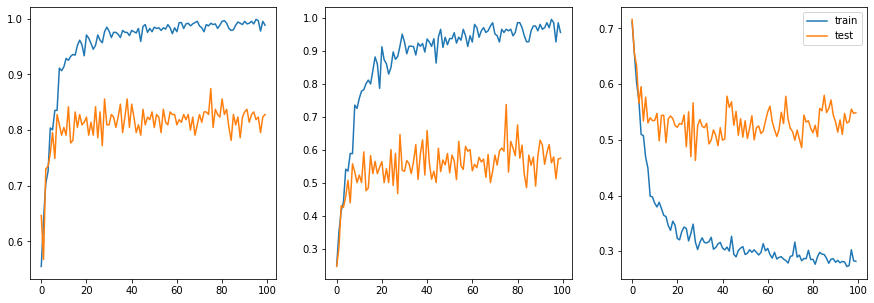

In [7]:
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Trainable parameters',trainable_count,'Non tranaible', non_trainable_count)


df_historic = pd.DataFrame(h.history)
df_historic.to_csv('results/'+f_name+'.csv')

fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].plot(df_historic['accuracy'].values, label='acc')
ax[0].plot(df_historic['val_accuracy'].values, label='val_acc')
ax[1].plot(df_historic['precision'].values)
ax[1].plot(df_historic['val_precision'].values)
ax[2].plot(df_historic['loss'].values, label='train')
ax[2].plot(df_historic['val_loss'].values, label='test')
plt.legend()

plt.show()

In [8]:
def print_metrics(tp,fp,fn,tn):
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    print('Accuracy:',accuracy)
    precision = tp/(tp+fp)
    print('Precision:',precision)
    recall = tp/(tp+fn)
    print('Recall:',recall)
    error = (fp+fn)/(tp+fp+fn+tn)
    print('Error rate:',error)
    sensivity = tp/(tp+fn)
    print('Sensivity:',sensivity)
    specificity = tn/(tn+fp)
    print('Specificity:',specificity)
    f1_Score = (2*precision*recall)/(precision+recall)
    print('F1-score:',f1_Score)

print('TRAINING')
print_metrics(df_historic.loc[epochs-1]['tp'],df_historic.loc[epochs-1]['fp'],df_historic.loc[epochs-1]['fn'],df_historic.loc[epochs-1]['tn'])

print('\nTEST')
print_metrics(df_historic.loc[epochs-1]['val_tp'],df_historic.loc[epochs-1]['val_fp'],df_historic.loc[epochs-1]['val_fn'],df_historic.loc[epochs-1]['val_tn'])

TRAINING
Accuracy: 0.9883177570093458
Precision: 0.9552238805970149
Recall: 0.9948186528497409
Error rate: 0.011682242990654205
Sensivity: 0.9948186528497409
Specificity: 0.9864253393665159
F1-score: 0.9746192893401014

TEST
Accuracy: 0.827906976744186
Precision: 0.5740740740740741
Recall: 0.6888888888888889
Error rate: 0.17209302325581396
Sensivity: 0.6888888888888889
Specificity: 0.8647058823529412
F1-score: 0.6262626262626262


In [12]:
images = validation_generator_normal.next()
image = images[0][0,:,:,:]
img_tensor = np.expand_dims(image, axis=0)

times = []
for i in range(15):
    start = time()
    model.predict(img_tensor, verbose=False)
    evaluation_time = (time()-start)
    times.append(evaluation_time)
    
print(np.median(np.array(times)),'seconds')
print(np.median(np.array(times)*1000),'milliseconds')

0.09174036979675293 seconds
91.74036979675293 milliseconds
